### **Task III: Quantum Convolutional Neural Network (QCNN) Part**

The task is to setup and apply a quantum convolutional neural network (QCNN) on particle physics data to perform binary classification on two types of objects (electrons and photons). You should use `tensorflow_quantum` for this task.


My implementation follows the approach elucidated in [1]

[1] Oh, Seunghyeok, Jaeho Choi, and Joongheon Kim. "A tutorial on quantum convolutional neural networks (QCNN)." _2020 International Conference on Information and Communication Technology Convergence (ICTC)_. IEEE, 2020.
APA	


In [ ]:
!pip install tensorflow==2.3.1

In [ ]:
!pip install tensorflow-quantum

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dataset = np.load('/content/drive/MyDrive/Colab Notebooks/GSoC QMLHEP/datasets/electron-photon.npz')

In [5]:
(x_train, y_train) = (dataset['x_train'], dataset['y_train'])
(x_test, y_test) = (dataset['x_test'], dataset['y_test'])

x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

In [6]:
x_train = tf.cast(x_train, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)

# Resize the images from the original 32x32 to 10x10
x_train = tf.image.resize(x_train[:], size=[10, 10]).numpy()
x_test = tf.image.resize(x_test[:], size=[10, 10]).numpy()

In [7]:
x_train[0].shape

(10, 10, 1)

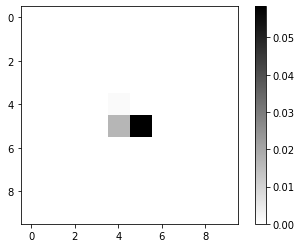

In [8]:
fig = plt.figure()
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [9]:
class QuantumConvLayer(tf.keras.layers.Layer):

  def __init__(self, filter_size, depth, activation=None, name=None, kernel_regularizer=None, **kwangs):
   super(QuantumConvLayer, self).__init__()
   self.filter_size = filter_size
   self.depth = depth
   self.activation = tf.keras.layers.Activation(activation)
   self.kernel_regularizer = kernel_regularizer
   self.learning_params = []
   self.make_QCNN_layer()

  def _next_qubits(self, current_size, next_size, qubits):
    steps = current_size // next_size
    qubit_list = []

    for i in range(0, current_size, step):
      for j in range(0, current_size, step):
        qubit_list.append(qubits[current_size * i + j])
    
    return qubit_list
  
  def _get_new_params(self):
    new_param = sympy.symbols("p" + str(len(self.learning_params)))
    self.learning_params.append(new_param)
    return new_param
  
  def _QuantumConvLayer(self, step, target, qubits):
    yield cirq.CZPowGate(exponent=self._get_new_params())(qubits[target], qubits[target+step])
    yield cirq.CXPowGate(exponent=self._get_new_params())(qubits[target], qubits[target+step])

  def make_QCNN_layer(self):
    pixels = self.filter_size**2
    qubit_grid = cirq.GridQubit.rect(self.filter_size, self.filter_size)
    input_circ = cirq.Circuit()
    input_params = [sympy.symbols(f'a{i}') for i in range(pixels)]
    for i, qubit in enumerate(qubit_grid):
      input_circ.append(cirq.rx(np.pi * input_params[i])(qubit))

      QCNN_circ = cirq.Circuit()
      steps = [2**i for i in range(np.log2(pixels).astype(np.int32))]
      for step in steps:
        for target in range(0, pixels, 2 * step):
          QCNN_circ.append(self._QuantumConvLayer(step, target, qubit_grid))
    
    # Putting it all together
    complete_circ = cirq.Circuit()
    complete_circ.append(input_circ)
    complete_circ.append(QCNN_circ)
    
    self.circuit = complete_circ
    self.params = input_params + self.learning_params
    self.op = cirq.Z(qubit_grid[0])

  def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = self.width - self.filter_size + 1
        self.num_y = self.height - self.filter_size + 1
        
        self.kernel = self.add_weight(name="kernel", shape=[self.depth, self.channel, len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)
  
  def single_depth_QCNN(self, input_data, controller, circuit_inputs):
    input_data = tf.concat([input_data, controller], 1)
    QCNN_output = tfq.layers.Expectation()(circuit_inputs, symbol_names=self.params, symbol_values=input_data, operators=self.op) 
    QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel])
    return tf.math.reduce_sum(QCNN_output, 3)
  
  def call(self, inputs):
    stack_set = None
    for i in range(self.num_x):
      for j in range(self.num_y):
        slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size, self.filter_size, -1])
        slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size, self.filter_size, self.channel])

        if stack_set == None:
          stack_set = slice_part
        else:
          stack_set = tf.concat([stack_set, slice_part], 1)
   
    stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
    stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size**2])
    circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
    circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
    tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
    outputs = []
    for i in range(self.depth):
        controller = tf.tile(self.kernel[i], [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
        outputs.append(self.single_depth_QCNN(stack_set, controller, circuit_inputs))
        
    output_tensor = tf.stack(outputs, axis=3)
    output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
    return self.activation(output_tensor)



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


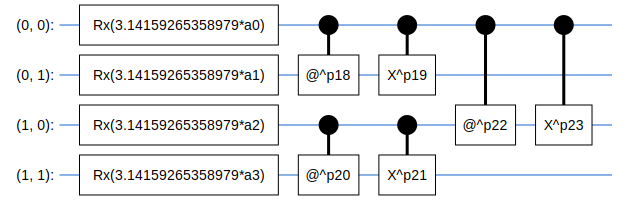

In [10]:
from cirq.contrib.svg import SVGCircuit
SVGCircuit(QuantumConvLayer(filter_size=2, depth=0, activation='relu').circuit)

In [39]:
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

qcnn = models.Sequential()

qcnn.add(QuantumConvLayer(filter_size=2, depth=8, activation='relu', name='QuantumConvolutionalLayer', input_shape=(width, height, 1)))
qcnn.add(layers.Flatten())
qcnn.add(layers.Dense(32, activation='relu'))
qcnn.add(layers.Dense(1, activation='sigmoid'))

In [40]:
qcnn.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
history = qcnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=40, batch_size=5)

Epoch 1/40
20/20 [==============================] - 17s 839ms/step - loss: 0.6948 - accuracy: 0.4400 - val_loss: 0.6935 - val_accuracy: 0.5200
Epoch 2/40
20/20 [==============================] - 16s 784ms/step - loss: 0.6921 - accuracy: 0.6300 - val_loss: 0.6944 - val_accuracy: 0.4400
Epoch 3/40
20/20 [==============================] - 16s 797ms/step - loss: 0.6914 - accuracy: 0.5600 - val_loss: 0.6950 - val_accuracy: 0.4600
Epoch 4/40
20/20 [==============================] - 16s 808ms/step - loss: 0.6909 - accuracy: 0.5600 - val_loss: 0.6959 - val_accuracy: 0.4600
Epoch 5/40
20/20 [==============================] - 17s 831ms/step - loss: 0.6899 - accuracy: 0.5600 - val_loss: 0.6965 - val_accuracy: 0.4600
Epoch 6/40
20/20 [==============================] - 17s 825ms/step - loss: 0.6893 - accuracy: 0.5600 - val_loss: 0.6974 - val_accuracy: 0.4600
Epoch 7/40
20/20 [==============================] - 16s 823ms/step - loss: 0.6886 - accuracy: 0.5600 - val_loss: 0.6980 - val_accuracy: 0.4600

In [42]:
test_loss, test_accuracy = qcnn.evaluate(x_test, y_test, verbose=2)

4/4 - 3s - loss: 0.7086 - accuracy: 0.4600


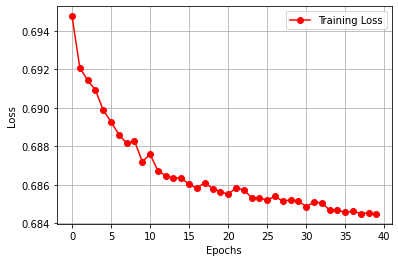

In [44]:
loss = history.history['loss']
fig = plt.figure()
plt.plot(np.arange(len(loss)), loss, 'ro-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)